Número de Atletas Únicos: 43
Categorias Presentes: [np.int64(48), np.int64(52), np.int64(57), np.int64(60), np.int64(63), np.int64(66), np.int64(70), np.int64(73), np.int64(78), np.int64(81), np.int64(90), np.int64(100)]
Total de Medições (Linhas): 1570


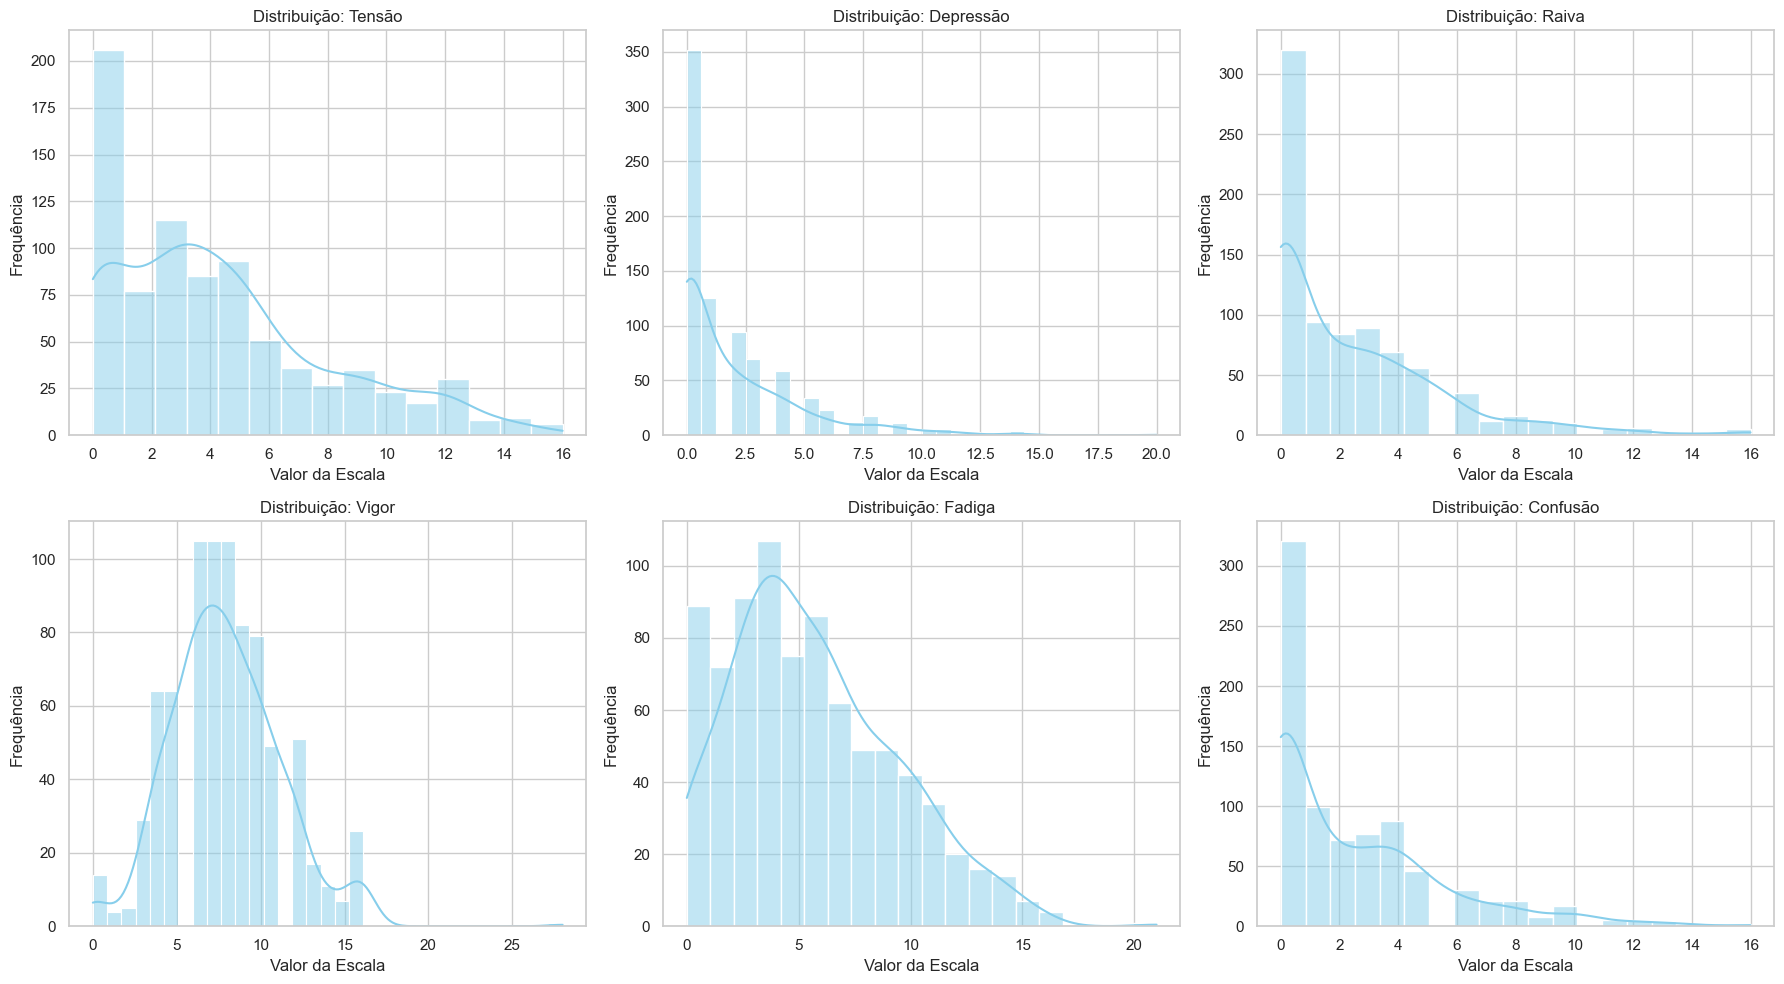


--- DISTRIBUIÇÃO DE LESÕES ---
Lesao_Ind
Sem Lesão    0.869427
Com Lesão    0.130573
Name: proportion, dtype: float64


C:\Users\edgar\AppData\Local\Temp\ipykernel_21672\2454485349.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_matrix.index, y=corr_matrix.values, palette='viridis')


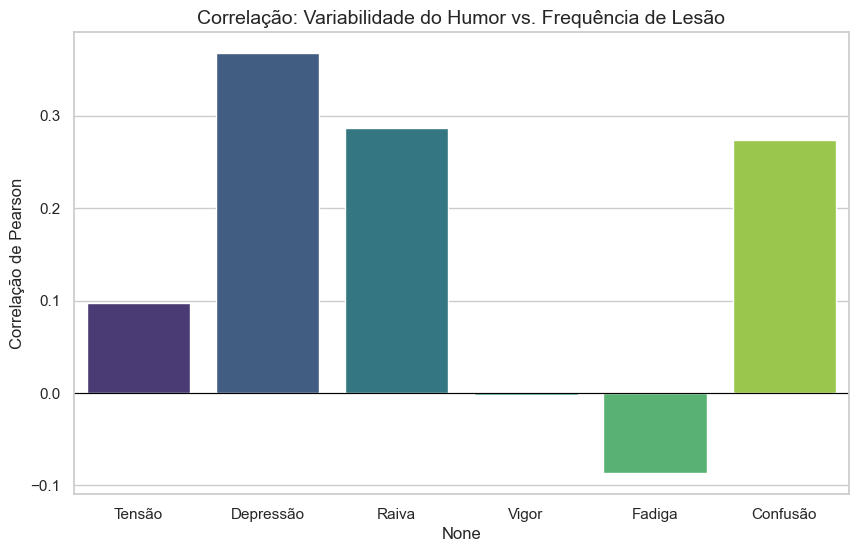


Correlações (Variabilidade -> Lesão):
Tensão       0.097552
Depressão    0.367743
Raiva        0.287209
Vigor       -0.002226
Fadiga      -0.086920
Confusão     0.273368
Name: Lesao_Ind, dtype: float64


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

df = pd.read_csv('dados.csv', sep=';', decimal=',')
df['Nascimento'] = pd.to_datetime(df['Nascimento'], dayfirst=True, errors='coerce')
df['Dia'] = pd.to_datetime(df['Dia'], dayfirst=True, errors='coerce')


print(f"Número de Atletas Únicos: {df['Atleta'].nunique()}")
print(f"Categorias Presentes: {sorted(df['Categoria'].unique())}")
print(f"Total de Medições (Linhas): {len(df)}")

# Analisando o Bruns 
brums_cols = ['Tensão', 'Depressão', 'Raiva', 'Vigor', 'Fadiga', 'Confusão']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten() 

for i, col in enumerate(brums_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribuição: {col}')
    axes[i].set_xlabel('Valor da Escala')
    axes[i].set_ylabel('Frequência')

plt.tight_layout()
plt.show() 




# Criando INDICADOR DE LESÃO E VARIÁVEIS DEMOGRÁFICAS
# Função para inferir Sexo baseado na Categoria de Peso do Judô
def infer_sex(cat):
    if cat in [48, 52, 57, 63, 70, 78]: return 'F'
    elif cat in [60, 66, 73, 81, 90, 100]: return 'M'
    else: return 'Unknown'

df['Sexo'] = df['Categoria'].apply(infer_sex)

# Cálculo da Idade na data da medição
df['Idade'] = (df['Dia'] - df['Nascimento']).dt.days / 365.25

# Criação do Indicador de Lesão (Target Atual)
# Consideramos lesão se houver valor em 'Afastamento T' OU 'Afastamento P'
df['Lesao_Ind'] = ((df['Afastamento T'].notnull()) | (df['Afastamento P'].notnull())).astype(int)

print("\n--- DISTRIBUIÇÃO DE LESÕES ---")
print(df['Lesao_Ind'].value_counts(normalize=True).rename({0: 'Sem Lesão', 1: 'Com Lesão'}))






# Variação no brums vs risco da lesão
brums_std = df.groupby('Atleta')[brums_cols].std()
injury_freq = df.groupby('Atleta')['Lesao_Ind'].mean()
analysis_df = brums_std.merge(injury_freq, left_index=True, right_index=True)
corr_matrix = analysis_df.corr()['Lesao_Ind'].drop('Lesao_Ind')

# Gráfico de Correlação
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_matrix.index, y=corr_matrix.values, palette='viridis')
plt.title('Correlação: Variabilidade do Humor vs. Frequência de Lesão', fontsize=14)
plt.ylabel('Correlação de Pearson')
plt.axhline(0, color='black', linewidth=0.8)
plt.show()

print("\nCorrelações (Variabilidade -> Lesão):")
print(corr_matrix)





# Rascunho - preparando para a modelagem
df = df.sort_values(by=['Atleta', 'Semana'])

df['Target_Lesao_Prox_Semana'] = df.groupby('Atleta')['Lesao_Ind'].shift(-1)

features_cols = [
    'Sexo', 'Idade', 'Categoria',    
    'PSE QUA', 'PSE SAB',             
    'TQR SEG', 'TQR SEX',             
    'Tensão', 'Depressão', 'Raiva',   
    'Vigor', 'Fadiga', 'Confusão',
    'Lesao_Ind'                       
]

Questões básicas do banco de dados:
A análise inicial da base de dados revelou a presença de 43 atletas distintos, distribuídos por 12 categorias de peso oficiais do Judô. Pela classificação de peso, foi possível inferir a divisão por sexo, abrangendo desde categorias ligeiras (ex: 48kg feminino, 60kg masculino) até as mais pesadas (ex: 78kg feminino, 100kg masculino). O conjunto de dados é composto por 1.570 medições (linhas), que acompanham esses atletas ao longo de diversas semanas. É importante notar que variáveis cruciais como a Percepção Subjetiva de Esforço (PSE) e o questionário BRUMS apresentam um preenchimento entre 50% e 60%, uma característica comum em estudos longitudinais esportivos onde a assiduidade no preenchimento diário pode variar.

Como é a variação no BRUMS:
Ao observar a distribuição das seis dimensões do humor, nota-se um comportamento distinto entre os estados negativos e positivos. As escalas de Tensão, Depressão, Raiva e Confusão apresentam uma distribuição fortemente "assimétrica à direita", ou seja, a grande maioria dos registros concentra-se em valores baixos ou zero, com poucos casos isolados de pontuações altas. Por outro lado, a variável Vigor tende a apresentar valores mais altos e uma distribuição mais próxima do normal. Esse padrão visual confirma a presença do chamado "Perfil Iceberg", que é esperado em atletas saudáveis e mentalmente equilibrados: alto vigor e baixos níveis de tensão, depressão, raiva, fadiga e confusão.

A variação intra-atleta no BRUMS pode explicar o risco de lesão:
Os dados sugerem que existe uma correlação relevante entre a instabilidade emocional e o risco físico. Ao calcular o desvio padrão das pontuações do BRUMS para cada atleta (representando o quanto o humor dele oscila) e cruzar com a frequência de afastamentos, encontrou-se uma correlação positiva moderada. O destaque foi a escala de Depressão (r ≈ 0.37), indicando que atletas com maiores oscilações neste sentimento tendem a se lesionar mais. Raiva e Confusão também mostraram associação positiva. Curiosamente, a variabilidade na Fadiga física mostrou pouca correlação direta com a frequência de lesões nesta amostra, sugerindo que, para este grupo, a instabilidade nos marcadores psicométricos (emocionais) pode ser um sinal de alerta prévio mais forte do que a variação na percepção de cansaço.

Como as variáveis de afastamento se comportam? É possível criar um indicador único de "lesão":
As variáveis originais Afastamento T (Treino) e Afastamento P (Preparação) são bastante esparsas, contendo muitos valores nulos. Quando preenchidas, seus valores variam significativamente (de 1 a 26 dias ou pontos de gravidade), o que dificulta uma modelagem numérica direta num primeiro momento. A estratégia recomendada e viável é a criação de um indicador único binário de "Lesão". Transformou-se o problema em uma classificação de risco: atribui-se o valor 0 quando ambos os campos são nulos (atleta apto) e o valor 1 quando há qualquer registro em T ou P. Isso simplifica a análise exploratória e treina o modelo para responder à pergunta essencial: "Haverá afastamento?" em vez de tentar prever a gravidade exata com dados escassos.

Preparação para um modelo preditivo: que variáveis poderiam ser incluídas? Sexo, idade, categoria, PSE, o quê mais:
Para a construção de um modelo de Machine Learning robusto capaz de prever o risco na semana seguinte, recomenda-se estruturar o dataset combinando quatro tipos de variáveis. Primeiro, as Demográficas fixas, incluindo Sexo (inferido pela categoria), Idade (calculada pelo nascimento) e a própria Categoria de peso. Segundo, as variáveis de Carga e Recuperação, utilizando a PSE para medir carga interna e o TQR para o estado de recuperação. Terceiro, os dados Psicométricos do BRUMS, onde além dos valores brutos semanais, é valioso incluir o "Z-score" (o desvio do atleta em relação à sua própria média histórica) para detectar anomalias de humor. Por fim, é crucial incluir o Histórico de Lesão (se o atleta estava afastado na semana anterior), pois lesões prévias são fortes preditores de reincidência ou continuidade do afastamento.

## Relação Brums X Afastamento

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
def processar_afastamentos(group):
    # Identifica onde há afastamento T ou P > 0
    condicao = ((group['Afastamento T'].notna() & (group['Afastamento T'] > 0)) | 
                (group['Afastamento P'].notna() & (group['Afastamento P'] > 0)))
    
    indices = np.where(condicao)[0]
    primeiro_afast = indices[0] + 1 if len(indices) > 0 else np.nan
    
    group['primeiro_afast'] = primeiro_afast
    group['linha'] = np.arange(1, len(group) + 1)
    return group

def plot_brum_com_limites(dados,var, lim_1, lim_2):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=dados, x='afastamento', y=var, hue='afastamento', palette='Set2')
    plt.axhline(lim_1, ls='--', color='darkorange', label=f'Limite {lim_1}')
    plt.axhline(lim_2, ls='--', color='red', label=f'Limite {lim_2}')
    plt.title(f"Distribuição de {var} no início do afastamento")
    plt.xlabel("Tipo de afastamento")
    plt.ylabel(var)
    plt.legend()
    plt.show()

In [15]:
df.columns

Index(['Atleta', 'Nascimento', 'Categoria', 'Semana', 'Dia', 'Período',
       'Competição', 'Pesagem', 'Afastamento T', 'Afastamento P', 'PSE QUA',
       'PSE SAB', 'TQR SEG', 'TQR QUA', 'TQR SEX', 'Tensão', 'Depressão',
       'Raiva', 'Vigor', 'Fadiga', 'Confusão', 'Notas', 'Teste Salto Squat',
       'Teste Salto CMJ', 'Teste Agachamento', 'Teste Supino', 'Teste Remada',
       'Teste Salto Tatame', 'Teste Barra', 'UK Velocidade', 'UK Resistência',
       'Sexo', 'Idade', 'Lesao_Ind', 'Target_Lesao_Prox_Semana'],
      dtype='object')

In [16]:
dados = df.groupby('Atleta', group_keys=False).apply(processar_afastamentos)
dados = dados[
    (dados['linha'] == (dados['primeiro_afast'] - 1)) |
    ((dados['Afastamento T'].notna() & (dados['Afastamento T'] > 0)) | 
     (dados['Afastamento P'].notna() & (dados['Afastamento P'] > 0)))
].copy()

# 3. Criar variável de tipo de afastamento (case_when)
condicoes = [
    (dados['Afastamento T'].notna() & (dados['Afastamento T'] > 0)),
    (dados['Afastamento P'].notna() & (dados['Afastamento P'] > 0))
]
escolhas = ['T', 'P']
dados['afastamento'] = np.select(condicoes, escolhas, default='Nenhum')

# Transformar em categoria com ordem específica (factor)
dados['afastamento'] = pd.Categorical(dados['afastamento'], categories=['Nenhum', 'P', 'T'], ordered=True)

# 4. Subconjunto início dos afastamentos
dados_inicio_afast = dados[
    (dados['Afastamento T'] == 1) | 
    (dados['Afastamento P'] == 1) | 
    (dados['Afastamento T'].isna() & dados['Afastamento P'].isna())
].copy()
# 5. Médias por grupo 
colunas_brum = ['Tensão', 'Depressão', 'Raiva', 'Vigor', 'Fadiga', 'Confusão']
resumo = dados_inicio_afast.groupby('afastamento')[colunas_brum].mean()

C:\Users\edgar\AppData\Local\Temp\ipykernel_21672\1745758224.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dados = df.groupby('Atleta', group_keys=False).apply(processar_afastamentos)
C:\Users\edgar\AppData\Local\Temp\ipykernel_21672\1745758224.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumo = dados_inicio_afast.groupby('afastamento')[colunas_brum].mean()


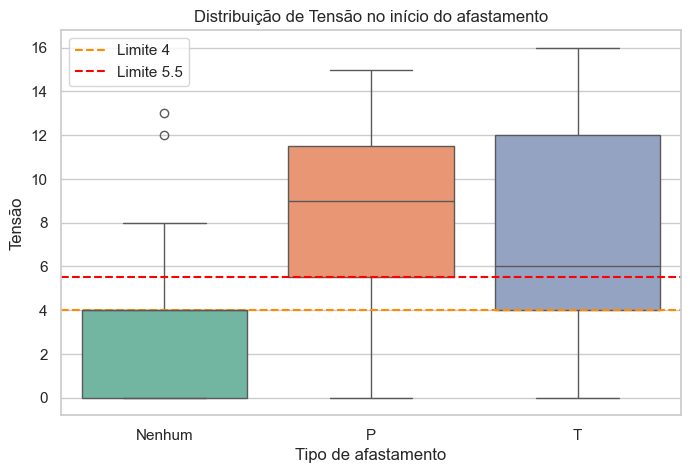

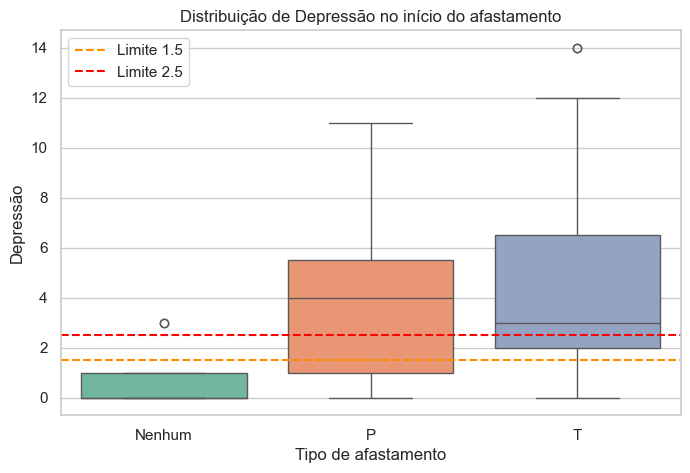

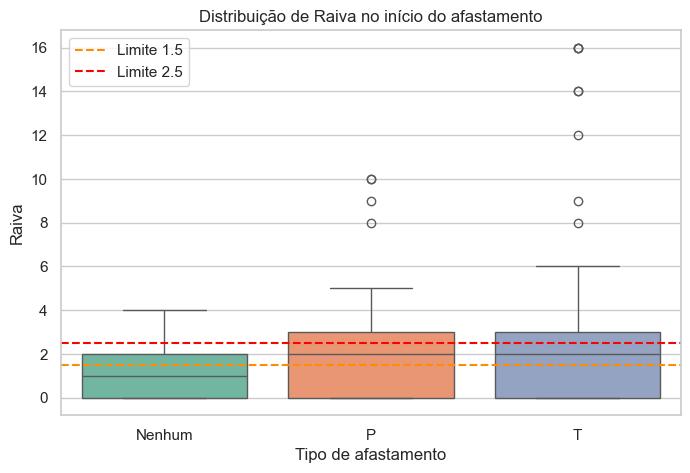

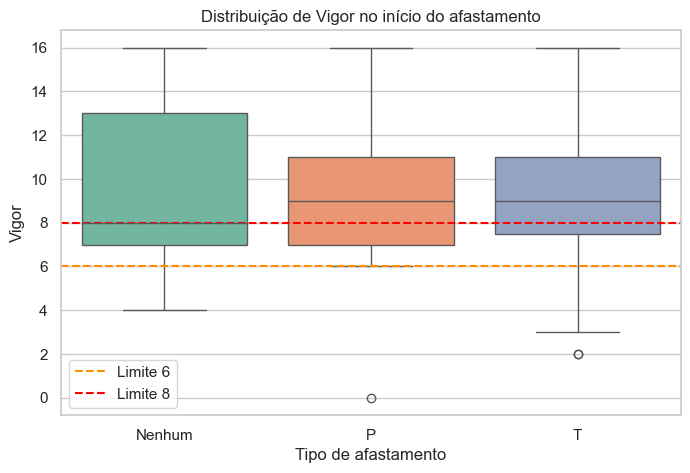

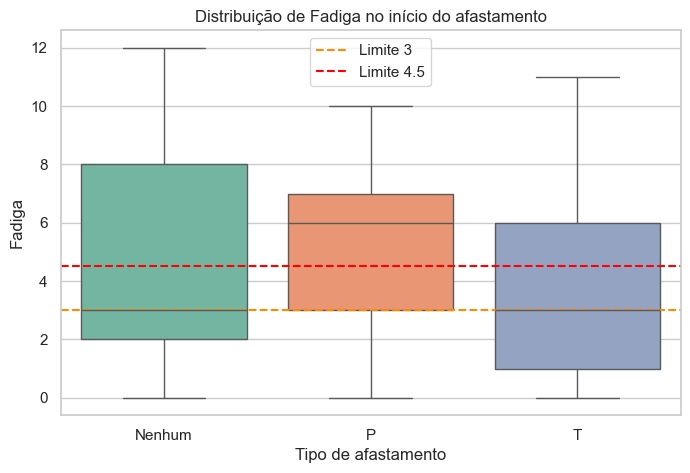

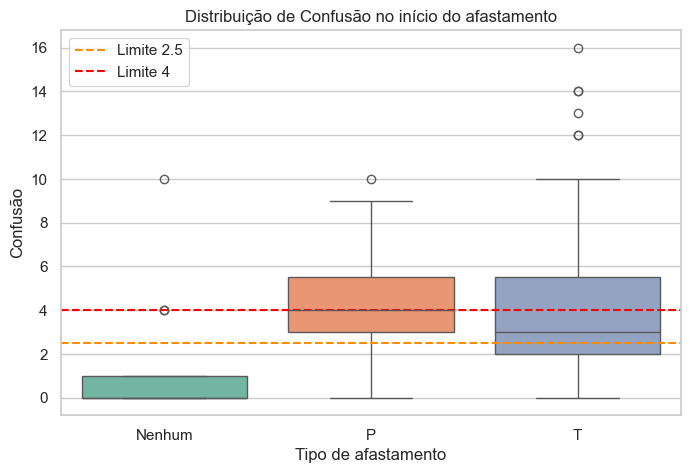

In [19]:
# 1. TENSÃO (Verde ≤ 4, Amarelo 4–5.5, Vermelho ≥ 5.5)
plot_brum_com_limites(dados,"Tensão", 4, 5.5)

# 2. DEPRESSÃO (Verde ≤ 1.5, Amarelo 1.5–2.5, Vermelho ≥ 2.5)
plot_brum_com_limites(dados,"Depressão", 1.5, 2.5)

# 3. RAIVA (Verde ≤ 1.5, Amarelo 1.5–2.5, Vermelho ≥ 2.5)
plot_brum_com_limites(dados,"Raiva", 1.5, 2.5)

# 4. VIGOR (Verde ≥ 8, Amarelo 6–8, Vermelho ≤ 6)
# → note que aqui o vermelho é valor BAIXO, então invertemos as cores
plot_brum_com_limites(dados,"Vigor", 6, 8)

# 5. FADIGA (Verde ≤ 3, Amarelo 3–4.5, Vermelho ≥ 4.5)
plot_brum_com_limites(dados,"Fadiga", 3, 4.5)

# 6. CONFUSÃO (Verde ≤ 2.5, Amarelo 2.5–4, Vermelho ≥ 4)
plot_brum_com_limites(dados,"Confusão", 2.5, 4)

## 3. Conclusão

Baseado nos boxplots de **Tensão, Depressão e Confusão**, observamos:

* **Padrão de Elevação**: Indivíduos nos grupos **P** e **T** apresentam escores medianos significativamente mais altos em estados de humor negativos em comparação ao grupo **Nenhum**.
* **Zonas de Risco**: 
    * Na **Tensão**, o grupo P já inicia o afastamento acima do limite crítico de 5.5.
    * Na **Depressão**, o grupo T demonstra maior variabilidade e presença de *outliers* extremos.
* **Implicação**: Os resultados validam o uso da escala BRUMS como ferramenta de triagem, demonstrando que o início do afastamento é precedido ou acompanhado por alterações psicométricas detectáveis.

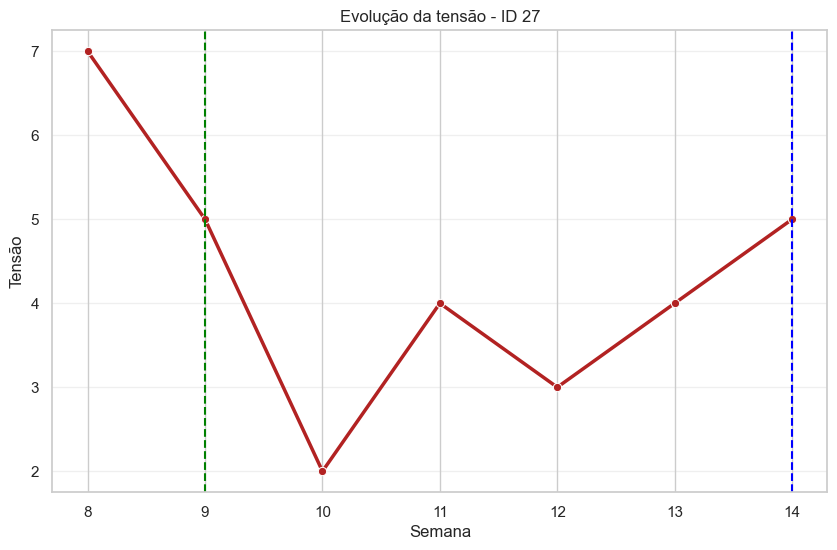

In [31]:
# 7. Gráfico de Evolução 
dado1 = dados[(dados['Atleta'] == 27) & (dados['Tensão'].notna())].copy()
semana_afast_P = dado1[dado1['Afastamento P'] == 1]['Semana'].tolist()
semana_afast_T = dado1[dado1['Afastamento T'] == 1]['Semana'].tolist()

plt.figure(figsize=(10, 6))
sns.lineplot(data=dado1, x='Semana', y='Tensão', marker='o', color='#B22222', linewidth=2.5)

for s in semana_afast_P: plt.axvline(s, color='blue', ls='--', label='Afast P')
for s in semana_afast_T: plt.axvline(s, color='green', ls='--', label='Afast T')

plt.title("Evolução da tensão - ID 27")
plt.grid(axis='y', alpha=0.3)
plt.show()

## rascunho mais geral